In [1]:
%reload_ext nb_black

<IPython.core.display.Javascript object>

In [2]:
import warnings

import pandas as pd
import numpy as np
import pickle

import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor

import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    fbeta_score,
    f1_score,
    make_scorer,
    accuracy_score,
)

from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler

from sklearn.linear_model import LogisticRegression, Lasso, RidgeClassifier

<IPython.core.display.Javascript object>

In [3]:
def print_vif(x):
    """Utility for checking multicollinearity assumption
    
    :param x: input features to check using VIF. This is assumed to be a pandas.DataFrame
    :return: nothing is returned the VIFs are printed as a pandas series
    """
    # Silence numpy FutureWarning about .ptp
    with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        x = sm.add_constant(x)

    vifs = []
    for i in range(x.shape[1]):
        vif = variance_inflation_factor(x.values, i)
        vifs.append(vif)

    print("VIF results\n-------------------------------")
    print(pd.Series(vifs, index=x.columns))
    print("-------------------------------\n")

<IPython.core.display.Javascript object>

In [4]:
# To use all
# df_long = pd.read_csv("../data/features_30_sec.csv")
# df_short = pd.read_csv("../data/features_3_sec.csv")
# df = pd.concat((df_long, df_short))

# To use just one
# df = pd.read_csv("../data/features_30_sec.csv")
df = pd.read_csv("../data/features_3_sec.csv")

df["genre"] = df["filename"].str.split(".").str[0]

# "blues.00000.0.wav" -> "blues.00000"
# and
# "blues.00000.wav" -> "blues.00000"
# logic: split on period, take first 2 elements, and but back together
df["songname"] = df["filename"].str.split(".").str[:2].str.join(".")

<IPython.core.display.Javascript object>

In [5]:
keep_cols = [
    "chroma_stft_mean",
    "chroma_stft_var",
    "rms_var",
    "zero_crossing_rate_mean",
    "harmony_mean",
    "harmony_var",
    "perceptr_mean",
    # "tempo",
    "mfcc1_mean",
    "mfcc2_mean",
    "mfcc2_var",
    "mfcc3_mean",
    "mfcc3_var",
    "mfcc4_mean",
    # "mfcc4_var",
    "mfcc5_var",
    "mfcc6_mean",
    "mfcc6_var",
    "mfcc7_mean",
    "mfcc8_mean",
    "mfcc8_var",
    "mfcc9_mean",
    "mfcc9_var",
    "mfcc10_var",
    "mfcc12_mean",
    "mfcc12_var",
    "mfcc13_mean",
    "mfcc15_mean",
    "mfcc15_var",
    "mfcc16_mean",
    "mfcc16_var",
    "mfcc17_mean",
    "mfcc18_mean",
    "mfcc19_mean",
    "mfcc19_var",
]

<IPython.core.display.Javascript object>

In [6]:
# X = df.drop(columns=drop_cols + ["genre"])
X = df[keep_cols]
y = df["genre"]

<IPython.core.display.Javascript object>

In [7]:
X_logged = X.copy()
for c in X_logged:
    if c.endswith("_var"):
        X_logged[c] = np.log(X_logged[c])

<IPython.core.display.Javascript object>

In [8]:
print_vif(X_logged)

VIF results
-------------------------------
const                      1421.874645
chroma_stft_mean              3.723235
chroma_stft_var               2.481061
rms_var                       4.003560
zero_crossing_rate_mean       4.948138
harmony_mean                  1.476700
harmony_var                   5.176070
perceptr_mean                 1.575498
mfcc1_mean                    8.748168
mfcc2_mean                    5.746644
mfcc2_var                     2.059273
mfcc3_mean                    2.390669
mfcc3_var                     2.375633
mfcc4_mean                    2.253628
mfcc5_var                     2.534218
mfcc6_mean                    3.356153
mfcc6_var                     2.906920
mfcc7_mean                    2.948474
mfcc8_mean                    3.603997
mfcc8_var                     2.500590
mfcc9_mean                    2.681704
mfcc9_var                     2.344943
mfcc10_var                    2.170304
mfcc12_mean                   2.441018
mfcc12_var          

<IPython.core.display.Javascript object>

In [24]:
# og: "blues.00000.0.wav"
# songname: "blues.00000"
# genre: "blues"
song_genre = df[["songname", "genre"]].drop_duplicates()

# train_songs, test_songs = train_test_split(
#     song_genre["songname"], test_size=0.2, random_state=42, stratify=song_genre["genre"]
# )

train_songs = pickle.load(open("../data/train_songs.p", "rb"))
test_songs = pickle.load(open("../data/test_songs.p", "rb"))

train_idxs = df[df["songname"].isin(train_songs)].index
test_idxs = df[df["songname"].isin(test_songs)].index

X_train = X_logged.loc[train_idxs, :]
X_test = X_logged.loc[test_idxs, :]
y_train = y[train_idxs]
y_test = y[test_idxs]

print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(7990, 33) (7990,)
(2000, 33) (2000,)


<IPython.core.display.Javascript object>

In [25]:
# Prove no overlap of songs between train/test
set(train_songs).intersection(set(test_songs))

set()

<IPython.core.display.Javascript object>

In [26]:
num_cols = list(X.columns)

preprocessing = ColumnTransformer(
    [
        # Scale numeric columns (not needed for all models but can't hurt)
        ("scaler", StandardScaler(), num_cols)
    ],
    remainder="passthrough",
)


pipeline = Pipeline(
    [
        ("preprocessing", preprocessing),
        #         ("pca", PCA()),
        # Choose your model and put it here
        ("log", LogisticRegression(max_iter=1000, penalty="l1", solver="saga", C=0.1),),
    ]
)

pipeline.fit(X_train, y_train)

print(pipeline.score(X_train, y_train))
print(pipeline.score(X_test, y_test))

0.6993742177722153
0.653


<IPython.core.display.Javascript object>

In [12]:
coef_df = pd.DataFrame(
    {"feat": X_train.columns, "coef": pipeline.named_steps["log"].coef_[0]}
)
coef_df["abs_coef"] = np.abs(coef_df["coef"])
coef_df.sort_values("abs_coef", ascending=False)

,feat,coef,abs_coef
7,mfcc1_mean,-1.987090,1.987090
8,mfcc2_mean,1.165546,1.165546
5,harmony_var,1.025689,1.025689
2,rms_var,0.987684,0.987684
14,mfcc6_mean,0.881589,0.881589
12,mfcc4_mean,0.875775,0.875775
9,mfcc2_var,-0.754643,0.754643
3,zero_crossing_rate_mean,0.673838,0.673838
16,mfcc7_mean,-0.475049,0.475049
13,mfcc5_var,0.436923,0.436923


<IPython.core.display.Javascript object>

In [13]:
y_pred = pipeline.predict(X_test)

print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))

[[117   0   7   1   0  27  10   0  21  17]
 [  0 193   0   0   0   6   0   0   0   1]
 [ 17   0 118   5   4   9   7   3   3  34]
 [  0   1   6 130  20   1   4  20   2  16]
 [  2   0   6  13  94   0  10  36  35   4]
 [  3  34  11   1   0 137   0   2   4   8]
 [  0   0   0  12   6   0 173   0   4   5]
 [  0   2   8   6  10   2   0 165   3   4]
 [  3   0  20  12  17   2   6   4 127   9]
 [ 15   2  14  41   5  15  35  18   3  52]]
              precision    recall  f1-score   support

       blues       0.75      0.58      0.66       200
   classical       0.83      0.96      0.89       200
     country       0.62      0.59      0.61       200
       disco       0.59      0.65      0.62       200
      hiphop       0.60      0.47      0.53       200
        jazz       0.69      0.69      0.69       200
       metal       0.71      0.86      0.78       200
         pop       0.67      0.82      0.74       200
      reggae       0.63      0.64      0.63       200
        rock       0.35     

<IPython.core.display.Javascript object>

In [14]:
df["predictions"] = pipeline.predict(X_logged[keep_cols])

<IPython.core.display.Javascript object>

In [15]:
long = pd.read_csv("../data/features_30_sec.csv")

<IPython.core.display.Javascript object>

In [16]:
long["vote_pred"] = "none"

for i in range(long["filename"].size):
    curr_file = long["filename"][i]
    file_stripped = curr_file.strip(".wav")
    sub_selection = df["filename"].str.contains(file_stripped)
    prediction = (
        df[sub_selection]["predictions"]
        .value_counts()
        .sort_values(ascending=False)
        .index[0]
    )
    long["vote_pred"][i] = prediction

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  del sys.path[0]


<IPython.core.display.Javascript object>

In [17]:
print(confusion_matrix(long["label"], long["vote_pred"]))
print(classification_report(long["label"], long["vote_pred"]))

[[75  0  3  1  2  4  6  0  3  6]
 [ 0 99  1  0  0  0  0  0  0  0]
 [ 8  0 73  4  0  3  1  3  1  7]
 [ 2  1  3 72  6  0  1  5  2  8]
 [ 2  0  1  5 71  0  2 11  6  2]
 [ 1  6  2  0  0 88  0  0  1  2]
 [ 2  0  0  2  1  0 93  0  1  1]
 [ 0  1  5  4  2  1  0 84  2  1]
 [ 6  0  6  2  8  3  1  7 66  1]
 [11  0  4 14  2  5 10  4  3 47]]
              precision    recall  f1-score   support

       blues       0.70      0.75      0.72       100
   classical       0.93      0.99      0.96       100
     country       0.74      0.73      0.74       100
       disco       0.69      0.72      0.71       100
      hiphop       0.77      0.71      0.74       100
        jazz       0.85      0.88      0.86       100
       metal       0.82      0.93      0.87       100
         pop       0.74      0.84      0.79       100
      reggae       0.78      0.66      0.71       100
        rock       0.63      0.47      0.54       100

    accuracy                           0.77      1000
   macro avg       

<IPython.core.display.Javascript object>

In [18]:
long_model_pred = long[keep_cols]
for c in long_model_pred:
    if c.endswith("_var"):
        long_model_pred[c] = np.log(long_model_pred[c])

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


<IPython.core.display.Javascript object>

In [19]:
long["model_pred"] = pipeline.predict(long_model_pred)

<IPython.core.display.Javascript object>

In [20]:
long.head()

,filename,length,chroma_stft_mean,chroma_stft_var,rms_mean,rms_var,spectral_centroid_mean,spectral_centroid_var,spectral_bandwidth_mean,spectral_bandwidth_var,...,mfcc17_var,mfcc18_mean,mfcc18_var,mfcc19_mean,mfcc19_var,mfcc20_mean,mfcc20_var,label,vote_pred,model_pred
0,blues.00000.wav,661794,0.350088,0.088757,0.130228,0.002827,1784.165850,129774.064525,2002.449060,85882.761315,...,36.524071,-0.408979,41.597103,-2.303523,55.062923,1.221291,46.936035,blues,blues,blues
1,blues.00001.wav,661794,0.340914,0.094980,0.095948,0.002373,1530.176679,375850.073649,2039.036516,213843.755497,...,60.314529,0.295073,48.120598,-0.283518,51.106190,0.531217,45.786282,blues,blues,reggae
2,blues.00002.wav,661794,0.363637,0.085275,0.175570,0.002746,1552.811865,156467.643368,1747.702312,76254.192257,...,47.639427,-1.816407,52.382141,-3.439720,46.639660,-2.231258,30.573025,blues,blues,blues
3,blues.00003.wav,661794,0.404785,0.093999,0.141093,0.006346,1070.106615,184355.942417,1596.412872,166441.494769,...,50.206673,0.636965,37.319130,-0.619121,37.259739,-3.407448,31.949339,blues,blues,blues
4,blues.00004.wav,661794,0.308526,0.087841,0.091529,0.002303,1835.004266,343399.939274,1748.172116,88445.209036,...,75.269707,-0.916874,53.613918,-4.404827,62.910812,-11.703234,55.195160,blues,blues,country


<IPython.core.display.Javascript object>

In [21]:
print(confusion_matrix(long["label"], long["model_pred"]))
print(classification_report(long["label"], long["model_pred"]))

[[73  0  7  2  1  1  3  0 11  2]
 [ 0 87  3  0  0  7  0  0  3  0]
 [ 5  0 70  6  1  0  1  6  8  3]
 [ 1  0  3 67  8  1  0 10  5  5]
 [ 2  0  0  4 68  0  2 10 13  1]
 [ 7  1  9  2  0 75  0  2  3  1]
 [ 1  0  0  3  8  0 82  0  1  5]
 [ 0  0  2  3  2  1  0 90  2  0]
 [ 5  0  4  1  6  0  0  6 76  2]
 [15  0  8 18  3  1  6  8  7 34]]
              precision    recall  f1-score   support

       blues       0.67      0.73      0.70       100
   classical       0.99      0.87      0.93       100
     country       0.66      0.70      0.68       100
       disco       0.63      0.67      0.65       100
      hiphop       0.70      0.68      0.69       100
        jazz       0.87      0.75      0.81       100
       metal       0.87      0.82      0.85       100
         pop       0.68      0.90      0.78       100
      reggae       0.59      0.76      0.66       100
        rock       0.64      0.34      0.44       100

    accuracy                           0.72      1000
   macro avg       

<IPython.core.display.Javascript object>

In [36]:
long.head()

,filename,length,chroma_stft_mean,chroma_stft_var,rms_mean,rms_var,spectral_centroid_mean,spectral_centroid_var,spectral_bandwidth_mean,spectral_bandwidth_var,...,mfcc17_var,mfcc18_mean,mfcc18_var,mfcc19_mean,mfcc19_var,mfcc20_mean,mfcc20_var,label,vote_pred,model_pred
0,blues.00000.wav,661794,0.350088,0.088757,0.130228,0.002827,1784.165850,129774.064525,2002.449060,85882.761315,...,36.524071,-0.408979,41.597103,-2.303523,55.062923,1.221291,46.936035,blues,blues,blues
1,blues.00001.wav,661794,0.340914,0.094980,0.095948,0.002373,1530.176679,375850.073649,2039.036516,213843.755497,...,60.314529,0.295073,48.120598,-0.283518,51.106190,0.531217,45.786282,blues,blues,reggae
2,blues.00002.wav,661794,0.363637,0.085275,0.175570,0.002746,1552.811865,156467.643368,1747.702312,76254.192257,...,47.639427,-1.816407,52.382141,-3.439720,46.639660,-2.231258,30.573025,blues,blues,blues
3,blues.00003.wav,661794,0.404785,0.093999,0.141093,0.006346,1070.106615,184355.942417,1596.412872,166441.494769,...,50.206673,0.636965,37.319130,-0.619121,37.259739,-3.407448,31.949339,blues,blues,blues
4,blues.00004.wav,661794,0.308526,0.087841,0.091529,0.002303,1835.004266,343399.939274,1748.172116,88445.209036,...,75.269707,-0.916874,53.613918,-4.404827,62.910812,-11.703234,55.195160,blues,blues,country


<IPython.core.display.Javascript object>

In [37]:
long["songname"] = long["filename"].str.split(".").str[:2].str.join(".")

<IPython.core.display.Javascript object>

In [39]:
train_idxs = long[long["songname"].isin(train_songs)].index
test_idxs = long[long["songname"].isin(test_songs)].index

train_idxs

Int64Index([  0,   1,   2,   3,   4,   6,   7,   8,   9,  10,
            ...
            985, 986, 989, 990, 992, 993, 995, 996, 997, 998],
           dtype='int64', length=800)

<IPython.core.display.Javascript object>

In [40]:
long_train = long.loc[train_idxs, :]
long_test = long.loc[test_idxs, :]

<IPython.core.display.Javascript object>

In [41]:
print(confusion_matrix(long_test["label"], long_test["vote_pred"]))
print(classification_report(long_test["label"], long_test["vote_pred"]))

[[12  0  1  0  0  3  1  0  2  1]
 [ 0 20  0  0  0  0  0  0  0  0]
 [ 1  0 15  0  0  1  1  0  0  2]
 [ 0  0  1 14  2  0  0  1  0  2]
 [ 0  0  0  1 12  0  1  4  2  0]
 [ 0  3  0  0  0 17  0  0  0  0]
 [ 0  0  0  1  1  0 18  0  0  0]
 [ 0  0  1  0  0  0  0 18  0  1]
 [ 0  0  2  0  2  0  1  0 14  1]
 [ 2  0  1  5  1  2  3  1  0  5]]
              precision    recall  f1-score   support

       blues       0.80      0.60      0.69        20
   classical       0.87      1.00      0.93        20
     country       0.71      0.75      0.73        20
       disco       0.67      0.70      0.68        20
      hiphop       0.67      0.60      0.63        20
        jazz       0.74      0.85      0.79        20
       metal       0.72      0.90      0.80        20
         pop       0.75      0.90      0.82        20
      reggae       0.78      0.70      0.74        20
        rock       0.42      0.25      0.31        20

    accuracy                           0.73       200
   macro avg       

<IPython.core.display.Javascript object>

In [58]:
print(confusion_matrix(long_train["label"], long_train["vote_pred"]))
print(classification_report(long_train["label"], long_train["vote_pred"]))

[[63  0  2  1  2  1  5  0  1  5]
 [ 0 79  1  0  0  0  0  0  0  0]
 [ 7  0 58  4  0  2  0  3  1  5]
 [ 2  1  2 58  4  0  1  4  2  6]
 [ 2  0  1  4 59  0  1  7  4  2]
 [ 1  3  2  0  0 71  0  0  1  2]
 [ 2  0  0  1  0  0 75  0  1  1]
 [ 0  1  4  4  2  1  0 66  2  0]
 [ 6  0  4  2  6  3  0  7 52  0]
 [ 9  0  3  9  1  3  7  3  3 42]]
              precision    recall  f1-score   support

       blues       0.68      0.79      0.73        80
   classical       0.94      0.99      0.96        80
     country       0.75      0.72      0.74        80
       disco       0.70      0.72      0.71        80
      hiphop       0.80      0.74      0.77        80
        jazz       0.88      0.89      0.88        80
       metal       0.84      0.94      0.89        80
         pop       0.73      0.82      0.78        80
      reggae       0.78      0.65      0.71        80
        rock       0.67      0.53      0.59        80

    accuracy                           0.78       800
   macro avg       

<IPython.core.display.Javascript object>

In [43]:
no_rock = long[long["label"] != "rock"]
print(confusion_matrix(no_rock["label"], no_rock["vote_pred"]))
print(classification_report(no_rock["label"], no_rock["vote_pred"]))

[[75  0  3  1  2  4  6  0  3  6]
 [ 0 99  1  0  0  0  0  0  0  0]
 [ 8  0 73  4  0  3  1  3  1  7]
 [ 2  1  3 72  6  0  1  5  2  8]
 [ 2  0  1  5 71  0  2 11  6  2]
 [ 1  6  2  0  0 88  0  0  1  2]
 [ 2  0  0  2  1  0 93  0  1  1]
 [ 0  1  5  4  2  1  0 84  2  1]
 [ 6  0  6  2  8  3  1  7 66  1]
 [ 0  0  0  0  0  0  0  0  0  0]]
              precision    recall  f1-score   support

       blues       0.78      0.75      0.77       100
   classical       0.93      0.99      0.96       100
     country       0.78      0.73      0.75       100
       disco       0.80      0.72      0.76       100
      hiphop       0.79      0.71      0.75       100
        jazz       0.89      0.88      0.88       100
       metal       0.89      0.93      0.91       100
         pop       0.76      0.84      0.80       100
      reggae       0.80      0.66      0.73       100
        rock       0.00      0.00      0.00         0

    accuracy                           0.80       900
   macro avg       

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1272: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


<IPython.core.display.Javascript object>

In [53]:
plot_df = pd.concat([X_logged, y], 1)
plot_df

,chroma_stft_mean,chroma_stft_var,rms_var,zero_crossing_rate_mean,harmony_mean,harmony_var,perceptr_mean,mfcc1_mean,mfcc2_mean,mfcc2_var,...,mfcc13_mean,mfcc15_mean,mfcc15_var,mfcc16_mean,mfcc16_var,mfcc17_mean,mfcc18_mean,mfcc19_mean,mfcc19_var,genre
0,0.335406,-2.396365,-5.649009,0.081851,-0.000078,-4.785064,-0.000068,-118.627914,125.083626,5.564355,...,-4.681614,-7.233477,3.755859,-2.853603,3.681027,-3.241280,0.722209,-5.050335,3.515064,blues
1,0.343065,-2.451706,-6.536409,0.087173,-0.000099,-5.308294,-0.000103,-125.590706,122.421227,5.378856,...,-7.717751,-8.300493,4.228071,4.074709,4.170507,-6.055294,0.159015,-2.837699,4.575029,blues
2,0.346815,-2.383330,-5.377274,0.071383,-0.000066,-4.383954,0.000065,-132.441940,115.085175,5.550325,...,-4.677677,-2.424750,3.918273,4.806280,4.209703,-1.768610,2.378768,-1.938424,3.971251,blues
3,0.363639,-2.443502,-6.012662,0.069426,-0.000014,-4.789304,0.000018,-118.231087,132.116501,5.807093,...,-4.362739,-9.889441,3.799220,-1.359111,3.865758,-3.841155,1.218588,-3.580352,3.928609,blues
4,0.335579,-2.428959,-6.376606,0.070095,0.000041,-4.642445,-0.000106,-105.968376,134.643646,5.391637,...,-5.681399,-7.986080,3.684292,2.092937,3.412347,0.664582,1.689446,-3.392489,3.286115,blues
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9985,0.349126,-2.519309,-9.236958,0.072885,-0.000034,-6.159446,-0.000020,-224.972168,141.034027,6.246245,...,-16.715929,-2.225949,4.386414,5.773784,3.749174,-9.094270,-4.246976,-5.625813,3.887814,rock
9986,0.372564,-2.493433,-9.341785,0.089111,-0.000027,-5.844111,-0.000045,-192.806641,118.249252,6.302588,...,-19.505360,-8.003813,3.533665,2.074155,3.478628,-12.375726,-3.081278,-11.960546,4.150288,rock
9987,0.347481,-2.418901,-7.262631,0.072194,0.000015,-6.009739,-0.000029,-287.840088,131.430176,6.898572,...,-13.186050,-9.124884,3.787080,-1.005473,4.359630,-2.524483,4.809936,1.775686,3.883261,rock
9988,0.387527,-2.467278,-8.045673,0.104072,0.000004,-5.604525,-0.000048,-162.659592,105.525452,5.829431,...,-14.699870,-5.266814,3.026968,4.123402,3.343700,-5.363541,6.462601,2.354765,3.212601,rock


<IPython.core.display.Javascript object>

In [54]:
top_five = list(coef_df.sort_values("abs_coef", ascending=False)["feat"])[:5]
top_five

['mfcc1_mean', 'mfcc2_mean', 'harmony_var', 'rms_var', 'mfcc6_mean']

<IPython.core.display.Javascript object>

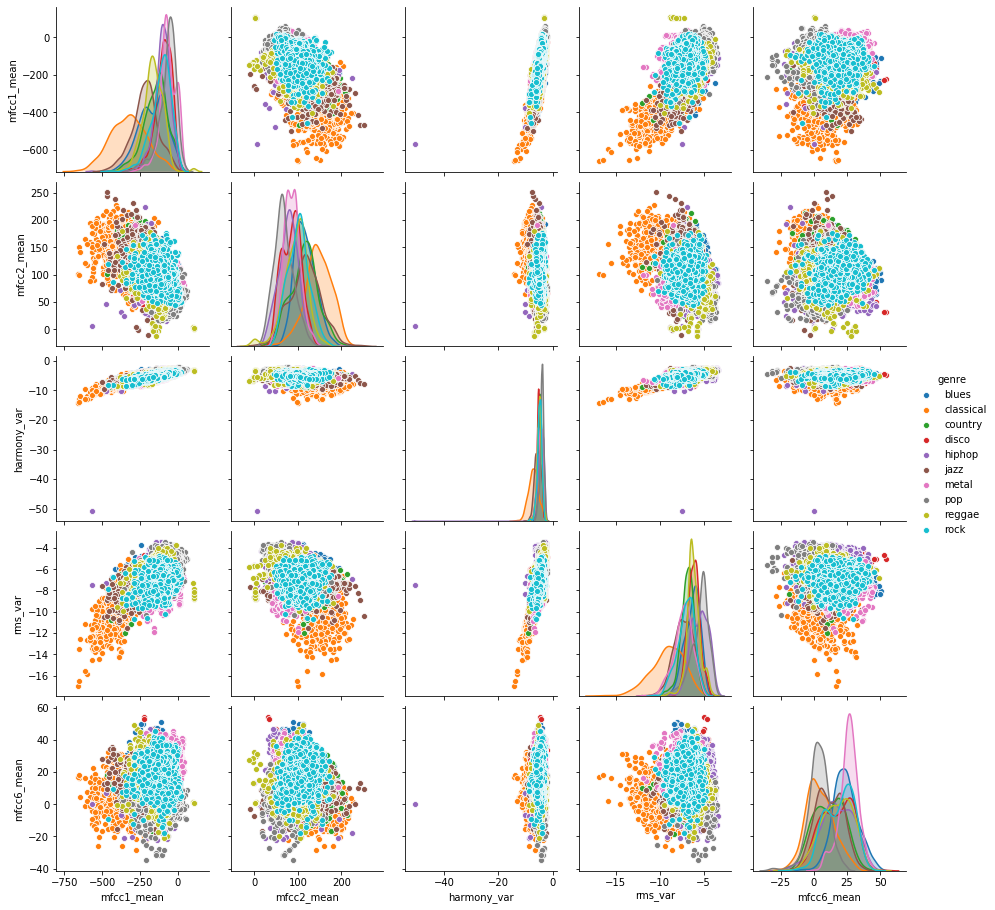

<IPython.core.display.Javascript object>

In [57]:
sns.pairplot(data=plot_df[top_five + ["genre"]], hue="genre")